# Redes Neuronales

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

2023-05-18 13:30:36.332141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## I Parte

In [98]:
# Cargar el set de datos MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to the range of 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

<class 'numpy.ndarray'>


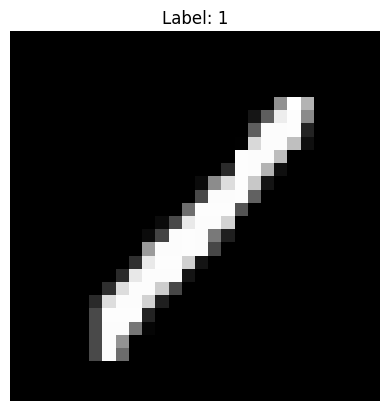

In [3]:
# Seleccionar dato random del dataset
index = np.random.randint(0, len(X_train))
image = X_train[index]

# Visualizar la imagen
plt.imshow(image, cmap='gray')
plt.title(f"Label: {y_train[index]}")
plt.axis('off')
plt.show()

In [4]:
#=== Feature Engineering ===#

# Reshape para pasarlas a 1D
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Estandarización de los datos
scaler = StandardScaler()
scaler.fit(X_train)
scaled_data = scaler.transform(X_train)
X_train = scaled_data

In [5]:
class Perceptron_Multicapa:
    def __init__(self, capas, alpha=0.1):
        self.capas = capas
        self.alpha = alpha
        self.bias = []
        self.pesos = []
        for i in range(0, len(capas) - 1):
            # Inicializar los pesos y bias de cada capa
            peso = np.random.randn(capas[i], capas[i+1])
            self.pesos.append(peso)
            bias = np.random.randn(capas[i+1])
            self.bias.append(bias)

    def activacion(self, x):
        # Función de activación sigmoide
        return 1.0 / (1 + np.exp(-x))

    def activacion_derivada(self, x):
        # Derivada de la función de activación sigmoide
        return x * (1 - x)

    def feedforward(self, X):
        # Calcular la salida de cada capa
        capa_activacion = [X]
        for i in range(0, len(self.capas) - 1):
            x = np.dot(capa_activacion[i], self.pesos[i]) + self.bias[i]
            y = self.activacion(x)
            capa_activacion.append(y)
        return capa_activacion

    def backpropagation(self, X, y, capa_activacion):
        # Calcular el error de la capa de salida
        error = capa_activacion[-1] - y
        delta = error * self.activacion_derivada(capa_activacion[-1])

        # Propagar el error hacia atrás a través de la red neuronal
        for i in reversed(range(0, len(self.capas) - 1)):
            activacion_actual = capa_activacion[i]
            activacion_anterior = capa_activacion[i-1] if i > 0 else X
            d_peso = np.outer(activacion_actual, delta)
            d_bias = delta
            self.pesos[i] -= self.alpha * d_peso
            self.bias[i] -= self.alpha * d_bias
            delta = np.dot(delta, self.pesos[i].T) * self.activacion_derivada(activacion_actual)

    def entrenar(self, X, y, epochs):
        for epoch in range(0, epochs):
            for i in range(0, len(X)):
                # Feedforward
                capa_activacion = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], capa_activacion)

    def predecir(self, X):
        # Obtener la salida de la última capa
        capa_activacion = self.feedforward(X)
        return capa_activacion[-1]
    

In [6]:
def computeMetrics(y_test, y_pred, training_time):
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "Tiempo de entrenamiento [s]":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

In [7]:
# Crear y entrenar el perceptrón multicapa
perceptron = Perceptron_Multicapa(capas=[784, 128, 10], alpha=0.15)

#Tomar tiempo de entrenamiento
start_time = time.time()
perceptron.entrenar(X_train, np.eye(10)[y_train], epochs=15)
end_time = time.time()
time_taken = end_time - start_time

# Hacer predicciones sobre el conjunto de prueba
predicciones = []
for i in range(len(X_test)):
    prediccion = perceptron.predecir(X_test[i])
    prediccion_clase = np.argmax(prediccion)
    predicciones.append(prediccion_clase)

# Calcular la precisión de las predicciones
computeMetrics(y_test, predicciones, time_taken)

/tmp/ipykernel_154142/3650226470.py:16: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


KeyboardInterrupt: 

## II Parte

In [8]:
class Perceptron_Multicapa_Multifuncion:
    def __init__(self, capas, funciones, alpha=0.1):
        self.capas = capas
        self.funciones = funciones
        self.alpha = alpha
        self.bias = []
        self.pesos = []
        self.activation_function_dict = {
            'sigmoid': self.activacion_sigmoid,
            'tanh': self.activacion_tanh,
            'relu': self.activacion_relu
        }
        self.derivate_function_dict = {
            'sigmoid': self.activacion_derivada_sigmoid,
            'tanh': self.activacion_derivada_tanh,
            'relu': self.activacion_derivada_relu
        }
        for i in range(0, len(capas) - 1):
            # Inicializar los pesos y bias de cada capa
            peso = np.random.randn(capas[i], capas[i+1])
            self.pesos.append(peso)
            bias = np.random.randn(capas[i+1])
            self.bias.append(bias)

    def activacion_sigmoid(self, x):
        # Función de activación sigmoide
        return 1.0 / (1 + np.exp(-x))

    def activacion_derivada_sigmoid(self, x):
        # Derivada de la función de activación sigmoide
        return x * (1 - x)

    def activacion_tanh(self, x):
        # Función de activación tanh
        return np.tanh(x)

    def activacion_derivada_tanh(self, x):
        # Derivada de la función de activación tanh
        return (1 - x**2)
    
    def activacion_relu(self, x):
        # Función de activación ReLU
        return np.maximum(0.1*x, x)
        
    def activacion_derivada_relu(self, x):
        # Derivada de la función de activación ReLU
        return np.where(x > 0, 1, 0.1)

    def feedforward(self, X):
        # Calcular la salida de cada capa
        capa_activacion = [X]
        for i in range(0, len(self.capas) - 1):
            #print('capa_activacion[i]', capa_activacion[i].shape)
            #print('self.pesos[i]', self.pesos[i].shape)
            x = np.dot(capa_activacion[i], self.pesos[i]) + self.bias[i]
            y = self.activation_function_dict.get(self.funciones[i], lambda: None)(x)
            capa_activacion.append(y)
        return capa_activacion

    def backpropagation(self, X, y, capa_activacion):
        # Calcular el error de la capa de salida
        error = capa_activacion[-1] - y
        delta = error * self.derivate_function_dict.get(self.funciones[-1], lambda: None)(capa_activacion[-1])

        # Propagar el error hacia atrás a través de la red neuronal
        for i in reversed(range(0, len(self.capas) - 1)):
            activacion_actual = capa_activacion[i]
            activacion_anterior = capa_activacion[i-1] if i > 0 else X
            d_peso = np.outer(activacion_actual, delta)
            d_bias = delta
            self.pesos[i] -= self.alpha * d_peso
            self.bias[i] -= self.alpha * d_bias
            delta = np.dot(delta, self.pesos[i].T) * self.derivate_function_dict.get(self.funciones[i], lambda: None)(activacion_actual)

    def entrenar(self, X, y, epochs):
        for epoch in range(0, epochs):
            for i in range(0, len(X)):
                # Feedforward
                capa_activacion = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], capa_activacion)

    def predecir(self, X):
        # Obtener la salida de la última capa
        capa_activacion = self.feedforward(X)
        return capa_activacion[-1]
    

In [9]:
def MLP_Functions(capas, funciones, alpha, epochs):

    # Crear y entrenar el perceptrón multicapa
    perceptron = Perceptron_Multicapa_Multifuncion(capas=capas, funciones=funciones, alpha=alpha)

    #Tomar tiempo de entrenamiento
    start_time = time.time()
    perceptron.entrenar(X_train, np.eye(10)[y_train], epochs=epochs)
    end_time = time.time()
    time_taken = end_time - start_time

    # Hacer predicciones sobre el conjunto de prueba
    predicciones = []
    for i in range(len(X_test)):
        prediccion = perceptron.predecir(X_test[i])
        prediccion_clase = np.argmax(prediccion)
        predicciones.append(prediccion_clase)

    # Calcular la precisión de las predicciones
    computeMetrics(y_test, predicciones, time_taken)

MLP_Functions([784, 8, 5, 10],['sigmoid','sigmoid', 'sigmoid'] , 0.15, 2)

/tmp/ipykernel_154142/3816873217.py:27: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento [s]
0,0.6622,0.7284,0.668419,0.667468,27.573038


In [105]:
# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with a different activation function
        self.fc3 = nn.Linear(64, output_size)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the MLP model
model = MLP(784, 10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Train the model
for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)

    y_train_tensor_long = y_train_tensor.long()
    y_train_tensor_onehot = F.one_hot(y_train_tensor_long, num_classes=output_size).float()

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the model
outputs = model(X_test)
_, predicted = torch.max(outputs.data, 1)
accuracy = (predicted == y_test).sum().item() / len(y_test)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1680000x28 and 784x128)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargar los datos de ejemplo (Iris dataset)
iris = load_iris()
X = iris.data
y = iris.target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los datos a tensores de PyTorch
X_entrenamiento = torch.Tensor(X_entrenamiento)
X_prueba = torch.Tensor(X_prueba)
y_entrenamiento = torch.Tensor(y_entrenamiento).long()
y_prueba = torch.Tensor(y_prueba).long()

# Definir la arquitectura de la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)  # Capa oculta 1
        self.fc2 = nn.Linear(100, 100)  # Capa oculta 2
        self.fc3 = nn.Linear(100, 3)  # Capa de salida
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Función de activación ReLU en la capa oculta 1
        x = torch.tanh(self.fc2(x))  # Función de activación tanh en la capa oculta 2
        x = self.fc3(x)  # Capa de salida sin función de activación
        return x

# Crear el modelo de la red neuronal
modelo = Net()

# Definir la función de pérdida y el optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.SGD(modelo.parameters(), lr=0.01)

# Entrenar la red neuronal
num_epochs = 1000
for epoch in range(num_epochs):
    # Paso de entrenamiento
    optimizador.zero_grad()
    salida = modelo(X_entrenamiento)
    perdida = criterio(salida, y_entrenamiento)
    perdida.backward()
    optimizador.step()

# Hacer predicciones sobre los datos de prueba
with torch.no_grad():
    salida = modelo(X_prueba)
    _, predicciones = torch.max(salida, 1)

# Calcular la precisión de las predicciones
precision = accuracy_score(y_prueba, predicciones)

print("Precisión:", precision)


Precisión: 1.0
